In [1]:
# declare a list tasks whose products you want to use as inputs
upstream = None


In [13]:
# Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging


# Add project root to path
sys.path.append(str(Path.cwd().parent))

from src.data_tools.preprocessor import load_and_clean_data
from src.data_tools.dataset import create_data_splits

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [14]:
# Configuration
# Define paths
DATA_DIR = Path('data')
PROCESSED_DATA_DIR = DATA_DIR / 'processed'

# Create directories if they don't exist
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Model configuration
config = {
    'train_size': 0.7,
    'val_size': 0.15,
    'test_size': 0.15,
    'random_state': 42
}


In [15]:
# Load Czech comment data
df_raw = load_and_clean_data(DATA_DIR, max_tweets_per_source=10000, max_tweets_per_author=50)

df_raw = df_raw.rename(columns={'account': 'author'})
df_raw = df_raw.rename(columns={'tweet': 'text'})

print("Raw dataset info:")
print(f"Total samples: {len(df_raw)}")
print(f"Columns: {df_raw.columns.tolist()}")
print("\nMissing values:")
print(df_raw.isnull().sum())

# Show class distribution
print("\nClass distribution:")
print(df_raw['troll'].value_counts(normalize=True))

INFO:src.data_tools.preprocessor:Loading Russian troll tweets...
INFO:src.data_tools.preprocessor:Loading Sentiment140 tweets...
INFO:src.data_tools.preprocessor:Loading celebrity tweets...
INFO:src.data_tools.preprocessor:Loading manualy scraped tweets...
INFO:src.data_tools.preprocessor:Loading Twitter JSON data from non_troll_politics folder...
INFO:src.data_tools.preprocessor:Loading information operations tweets...
INFO:src.data_tools.preprocessor:Found 151 parquet files in information_operations folder and its subdirectories
INFO:src.data_tools.preprocessor:Information operations data distribution - Trolls: 585379, Non-trolls: 914607
INFO:src.data_tools.preprocessor:Loading data collected by Machova...
INFO:src.data_tools.preprocessor:Combining datasets...
INFO:src.data_tools.preprocessor:Filtering accounts with few tweets...


Raw dataset info:
Total samples: 823137
Columns: ['author', 'text', 'troll', 'language']

Missing values:
author         0
text           0
troll          0
language    1748
dtype: int64

Class distribution:
troll
0    0.824575
1    0.175425
Name: proportion, dtype: float64



Language distribution:
language
en           0.525487
ru           0.157422
es           0.129465
ar           0.034048
pt           0.026621
               ...   
am           0.000001
hungarian    0.000001
greek        0.000001
dv           0.000001
gu           0.000001
Name: proportion, Length: 105, dtype: float64


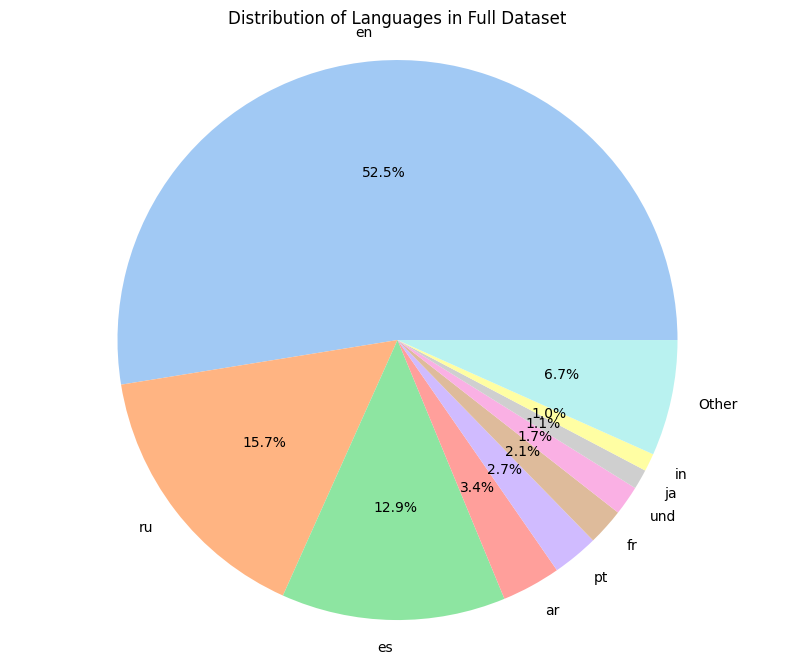

In [22]:
# Print language distribution
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Standardize language codes
df_raw['language'] = df_raw['language'].str.lower()
df_raw['language'] = df_raw['language'].replace({'english': 'en', 'russian': 'ru'})

print("\nLanguage distribution:")
print(df_raw['language'].value_counts(normalize=True))

# Create pie chart of language distribution
plt.figure(figsize=(10, 8))
language_counts = df_raw['language'].value_counts()

# Pool small slices into "Other"
threshold = 0.01  # 1%
mask = language_counts/language_counts.sum() >= threshold
other = pd.Series({'Other': language_counts[~mask].sum()})
language_counts = pd.concat([language_counts[mask], other])

# Use seaborn color palette with distinct colors
colors = sns.color_palette("pastel", n_colors=len(language_counts))

plt.pie(language_counts.values, 
        labels=language_counts.index, 
        autopct='%1.1f%%',
        colors=colors)
plt.title('Distribution of Languages in Full Dataset')
plt.axis('equal')
plt.show()


In [23]:
# Filter for English language tweets
df_raw = df_raw[df_raw['language'].str.lower().isin(['ru', 'russian'])]

print("\nAfter filtering for Russian tweets:")
print(f"Total samples: {len(df_raw)}")
print("\nClass distribution after filtering:")
print(df_raw['troll'].value_counts(normalize=True))



After filtering for Russian tweets:
Total samples: 129305

Class distribution after filtering:
troll
0    0.510321
1    0.489679
Name: proportion, dtype: float64


In [25]:
# Count tweets by troll label and author stats
tweet_counts = df_raw['troll'].value_counts()
total_tweets = len(df_raw)

# Get author stats split by troll/non-troll
author_stats = df_raw.groupby(['author', 'troll']).size().reset_index()
troll_authors = author_stats[author_stats['troll'] == 1]['author'].nunique()
nontroll_authors = author_stats[author_stats['troll'] == 0]['author'].nunique()
total_authors = troll_authors + nontroll_authors

# Calculate average tweets per author type
troll_tweets_per_author = df_raw[df_raw['troll'] == 1].groupby('author').size()
nontroll_tweets_per_author = df_raw[df_raw['troll'] == 0].groupby('author').size()
avg_troll_tweets = troll_tweets_per_author.mean()
avg_nontroll_tweets = nontroll_tweets_per_author.mean()

print("Tweet distribution:")
print(f"Troll tweets: {tweet_counts[1]:,} ({tweet_counts[1]/total_tweets:.1%})")
print(f"Non-troll tweets: {tweet_counts[0]:,} ({tweet_counts[0]/total_tweets:.1%})")
print(f"Total tweets: {total_tweets:,}")
print(f"\nAuthor statistics:")
print(f"Troll authors: {troll_authors:,} ({troll_authors/total_authors:.1%})")
print(f"Non-troll authors: {nontroll_authors:,} ({nontroll_authors/total_authors:.1%})")
print(f"Average tweets per troll author: {avg_troll_tweets:.1f}")
print(f"Average tweets per non-troll author: {avg_nontroll_tweets:.1f}")

print(f"Total samples: {len(df_raw)}")
print(f"Total authors: {df_raw['author'].nunique()}")
print("\nClass distribution:")
print(df_raw['troll'].value_counts(normalize=True))

Tweet distribution:
Troll tweets: 63,318 (49.0%)
Non-troll tweets: 65,987 (51.0%)
Total tweets: 129,305

Author statistics:
Troll authors: 2,096 (30.1%)
Non-troll authors: 4,875 (69.9%)
Average tweets per troll author: 30.2
Average tweets per non-troll author: 13.5
Total samples: 129305
Total authors: 6971

Class distribution:
troll
0    0.510321
1    0.489679
Name: proportion, dtype: float64


In [7]:
# Filter out authors with less than 10 tweets
author_tweet_counts = df_raw.groupby('author').size()
authors_with_enough_tweets = author_tweet_counts[author_tweet_counts >= 10].index
df_raw = df_raw[df_raw['author'].isin(authors_with_enough_tweets)]

print("Tweet distribution after filtering for authors with at least 10 tweets:")
print(f"Troll tweets: {tweet_counts[1]:,} ({tweet_counts[1]/total_tweets:.1%})")
print(f"Non-troll tweets: {tweet_counts[0]:,} ({tweet_counts[0]/total_tweets:.1%})")
print(f"Total tweets: {total_tweets:,}")
print(f"\nAuthor statistics:")
print(f"Troll authors: {troll_authors:,} ({troll_authors/(troll_authors+nontroll_authors):.1%})")
print(f"Non-troll authors: {nontroll_authors:,} ({nontroll_authors/(troll_authors+nontroll_authors):.1%})")
print(f"Average tweets per troll author: {avg_troll_tweets:.1f}")
print(f"Average tweets per non-troll author: {avg_nontroll_tweets:.1f}")


Tweet distribution after filtering for authors with at least 10 tweets:
Troll tweets: 63,318 (49.0%)
Non-troll tweets: 65,987 (51.0%)
Total tweets: 129,305

Author statistics:
Troll authors: 2,096 (30.1%)
Non-troll authors: 4,875 (69.9%)
Average tweets per troll author: 30.2
Average tweets per non-troll author: 13.5


In [ ]:
# Resample non-troll authors to only keep 10%
non_troll_authors = df_raw[df_raw['troll'] == 0]['author'].unique()
sampled_non_troll_authors = np.random.choice(
    non_troll_authors,
    size=int(len(non_troll_authors) * 0.2),
    replace=False
)

# Keep all troll authors and only sampled non-troll authors
troll_tweets = df_raw[df_raw['troll'] == 1]
sampled_non_troll_tweets = df_raw[
    (df_raw['troll'] == 0) & 
    (df_raw['author'].isin(sampled_non_troll_authors))
]
df_raw = pd.concat([troll_tweets, sampled_non_troll_tweets])

print("Tweet distribution:")
print(f"Troll tweets: {tweet_counts[1]:,} ({tweet_counts[1]/total_tweets:.1%})")
print(f"Non-troll tweets: {tweet_counts[0]:,} ({tweet_counts[0]/total_tweets:.1%})")
print(f"Total tweets: {total_tweets:,}")
print(f"\nAuthor statistics:")
print(f"Troll authors: {troll_authors:,} ({troll_authors/(troll_authors+nontroll_authors):.1%})")
print(f"Non-troll authors: {nontroll_authors:,} ({nontroll_authors/(troll_authors+nontroll_authors):.1%})")
print(f"Average tweets per troll author: {avg_troll_tweets:.1f}")
print(f"Average tweets per non-troll author: {avg_nontroll_tweets:.1f}")



After resampling non-troll authors to 10%:
Total samples: 121140
Total authors: 4742

Class distribution:
troll
0    0.504028
1    0.495972
Name: proportion, dtype: float64


In [8]:
# Count tweets by troll label and author stats
tweet_counts = df_raw['troll'].value_counts()
total_tweets = len(df_raw)

# Get author stats split by troll/non-troll
author_stats = df_raw.groupby(['author', 'troll']).size().reset_index()
troll_authors = author_stats[author_stats['troll'] == 1]['author'].nunique()
nontroll_authors = author_stats[author_stats['troll'] == 0]['author'].nunique()

# Calculate average tweets per author type
troll_tweets_per_author = df_raw[df_raw['troll'] == 1].groupby('author').size()
nontroll_tweets_per_author = df_raw[df_raw['troll'] == 0].groupby('author').size()
avg_troll_tweets = troll_tweets_per_author.mean()
avg_nontroll_tweets = nontroll_tweets_per_author.mean()

print("Tweet distribution:")
print(f"Troll tweets: {tweet_counts[1]:,} ({tweet_counts[1]/total_tweets:.1%})")
print(f"Non-troll tweets: {tweet_counts[0]:,} ({tweet_counts[0]/total_tweets:.1%})")
print(f"Total tweets: {total_tweets:,}")
print(f"\nAuthor statistics:")
print(f"Troll authors: {troll_authors:,} ({troll_authors/(troll_authors+nontroll_authors):.1%})")
print(f"Non-troll authors: {nontroll_authors:,} ({nontroll_authors/(troll_authors+nontroll_authors):.1%})")
print(f"Average tweets per troll author: {avg_troll_tweets:.1f}")
print(f"Average tweets per non-troll author: {avg_nontroll_tweets:.1f}")

Tweet distribution:
Troll tweets: 61,517 (53.6%)
Non-troll tweets: 53,238 (46.4%)
Total tweets: 114,755

Author statistics:
Troll authors: 1,806 (42.5%)
Non-troll authors: 2,439 (57.5%)
Average tweets per troll author: 34.1
Average tweets per non-troll author: 21.8


In [9]:
# Create Train/Val/Test Splits
# Create splits ensuring no author overlap
train_df, val_df, test_df = create_data_splits(
    df_raw,
    train_size=config['train_size'],
    val_size=config['val_size'],
    test_size=config['test_size'],
    random_state=config['random_state']
)

print("Dataset splits:")
print(f"Train: {len(train_df)} samples, {train_df['author'].nunique()} authors")
print(f"Val:   {len(val_df)} samples, {val_df['author'].nunique()} authors")
print(f"Test:  {len(test_df)} samples, {test_df['author'].nunique()} authors")

Dataset splits:
Train: 80735 samples, 2971 authors
Val:   17336 samples, 637 authors
Test:  16684 samples, 637 authors


In [11]:
# Save Processed Data
# Save splits to parquet
for split_name, split_df in [
    ('train_ru_only', train_df),
    ('val_ru_only', val_df),
    ('test_ru_only', test_df)
]:
    output_path = PROCESSED_DATA_DIR / f'{split_name}.parquet'
    split_df.to_parquet(output_path, index=False)
    print(f"Saved {split_name} split to {output_path}")



Saved train_ru_only split to data/processed/train_ru_only.parquet
Saved val_ru_only split to data/processed/val_ru_only.parquet
Saved test_ru_only split to data/processed/test_ru_only.parquet
